# Introduction

In this tutorial, we will introduce how to import a pre-made [``Condynsate``](https://github.com/GrayKS3248/condynsate) project, how to build a controller, how to run the pre-made [``Condynsate``](https://github.com/GrayKS3248/condynsate) project, and how to post-process the simulation data. The example project in this notebook is a quadrotor in a race course. The goal is to explore how external inputs applied to the system cause the system to behave. We will do this by interacting with the quadrotor via keyboard inputs (or algorithmic inputs) and then graphing the results.

# Build the Simulation Environment


When starting any Python project, the first thing to do is import dependencies. In this project, we will need the ``ae352_quadrotor`` module.

In [298]:
# Import the quadrotor project. This module is used to simulate, render, and plot a quadrotor dynamic system
import ae352_quadrotor

For post processing the data, we will also need the [``numpy``](https://numpy.org/) and [``matplotlib.pyplot``](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) modules.

In [299]:
# Import the pyplot module from the matplotlib package. This is used for graphing data
import matplotlib.pyplot as plt

# Import numpy module. This is used for numerical analysis and manipulation
import numpy as np

# Import Libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from sympy.physics import mechanics
from sympy import *
mechanics.init_vprinting()
import scipy as scipy
from scipy import linalg
from scipy import signal

We now need to initialize and instance of the simulator. There are four main parameters to the Quadrotor_Sim class initialization function:
#### Parameters

> **use_keyboard** : *bool, optional*  
> A boolean flag that indicates whether the simulation will allow the use of keyboard interactivity. The default is True.
> 
> **visualization** : *bool, optional*  
> A boolean flag that indicates whether the simulation will be  visualized in meshcat. The default is True.
> 
> **animation** : *bool, optional*  
> A boolean flag that indicates whether animated plots are created in real time. The default is True.
>
>  **verbose** : *bool, optional*  
> A boolean flag that indicates whether warnings are printing during  function execution. The default is False  .

To create a new instance of the simulator, we run the following code. This will also open our visualization and animation windows (if enabled).

In [300]:
# Make an instance of the simulator
sim = ae352_quadrotor.Quadrotor_Sim(use_keyboard=True,
                                    visualization=True,
                                    animation=False,
                                    verbose=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


If the visualization window is open, you will see a blue quadrotor with 1 sphere on each rotor. The **black** sphere denotes the body-fixed +x direction (forward), the **red** sphere denotes the body-fixed +y direction (left), the **green** sphere denotes the body-fixed -y direction (right), and the **white** sphere denotes the body-fixed -x direction (backwards).

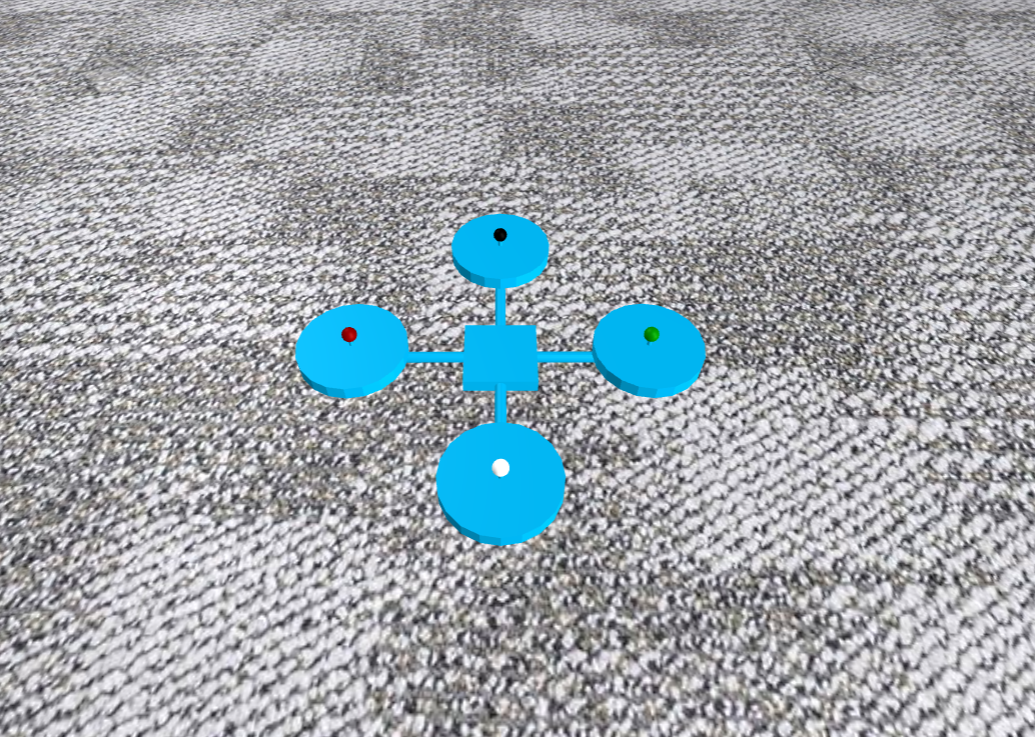

# Build a Manual (Or Automatic Controller)

The next step is to make a piece of code that can apply inputs (forces and torques) to the quadrotor. Now that the simulator is created, we can make our own controller. In the scope of AE352 and AE353, all controllers will have the same format as the one below. Specifically, all controllers will be a class that includes **exactly** three functions:
```python
def __init__(self)
def reset(self)
def run(self, **kwargs)
```
Descriptions for these functions are provided below in the ``Controller`` class.

As set up currently, this ``Controller`` class listens to your keyboard inputs and adjusts the forces and torques applied to the quadrotor. You can change how this works by modifying the output of the ``run`` function.

In [301]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
#m = nsimplify(0.97040424)
#Ix = nsimplify(0.0325132)
#Iy = nsimplify(0.0325132)
#Iz = nsimplify(0.06503)

m_motor = 0.189942
m_center = 0.138
m_rod = 0.075
m_battery = 0.16556
m_speed_controller = 0.04082331
m_prop = 0.04479225

m = m_motor + m_center + 4*m_rod + m_battery + 4*m_speed_controller + 4*m_prop

l_center = 0.096
h_center = 0.002992

l_rod = 0.177
d_rod_to_center = 0.0679
d_rod_to_axis = 0.048

d_motor_to_center = 0.2449
d_motor_to_axis = (0.096/2) + 0.177*np.sin(np.pi/4)

d_controller_to_center =0.1564
d_controller_to_axis = (0.048 + (0.177/2)*np.sin(np.pi/4))

d_propeller_to_center = 0.2449
d_propeller_to_axis = (0.096/2) + 0.177*np.sin(np.pi/4)

Ix_center_and_battery = ((1/12)*(m_center+m_battery)*(h_center**2 + l_center**2)) 
Ix_rod = 4*m_rod*((1/3)*(l_rod**2*np.sin(np.pi/4)**2) + d_rod_to_axis**2) 
Ix_motor = 4*m_motor*d_motor_to_axis**2 
Ix_speed_controller = 4*m_speed_controller*d_controller_to_axis**2 
Ix_propeller = 4*m_prop*d_propeller_to_axis**2

Ix = Ix_center_and_battery + Ix_rod + Ix_motor + Ix_speed_controller + Ix_propeller
Iy = Ix

Iz_center_and_battery = (1/12)*(m_center + m_battery)*(l_center**2 + l_center**2)
Iz_rod = 4*((1/3)*m_rod*l_rod**2 + m_rod*d_rod_to_center**2)
Iz_motor = 4*m_motor*d_motor_to_center**2
Iz_speed_controller = 4*m_speed_controller*d_controller_to_center**2
Iz_propeller = 4* m_prop*d_propeller_to_center**2
Iz = Iz_center_and_battery + Iz_rod + Iz_motor + Iz_speed_controller + Iz_propeller

print(m)
print(Ix)
print(Iz)

l = nsimplify(0.177)
g = nsimplify(9.81)


I = Matrix([[Ix,0,0],[0,Iy,0],[0,0,Iz]])

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rx @ Ry @ Rz

display(R_body_in_world)

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rz).T @ ex, Rz.T @ ey, ez).inv(), full=True)
display(M)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    I.inv() @ (tau_in_body - w_in_body.cross(I @ w_in_body)),
)

f = sym.simplify(f, full=True)
display(f)
h = sym.Matrix([[p_x],
                [p_y], 
                [p_z],
                [phi], 
                [theta], 
                [psi],
                [v_x], 
                [v_y], 
                [v_z],
                [w_x], 
                [w_y], 
                [w_z]])
p = sym.Matrix([[tau_x],
                [tau_y], 
                [tau_z],
                [f_z]])

1.13596424
0.03264047826753478
0.06529029547328041


⎡           cos(ψ)⋅cos(θ)                         -sin(ψ)⋅cos(θ)              
⎢                                                                             
⎢sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)  -sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)  
⎢                                                                             
⎣sin(φ)⋅sin(ψ) - sin(θ)⋅cos(φ)⋅cos(ψ)  sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ)   

    sin(θ)    ⎤
              ⎥
-sin(φ)⋅cos(θ)⎥
              ⎥
cos(φ)⋅cos(θ) ⎦

⎡    cos(ψ)        -sin(ψ)       ⎤
⎢    ──────        ────────     0⎥
⎢    cos(θ)         cos(θ)       ⎥
⎢                                ⎥
⎢    sin(ψ)         cos(ψ)      0⎥
⎢                                ⎥
⎣-cos(ψ)⋅tan(θ)  sin(ψ)⋅tan(θ)  1⎦

⎡                            vₓ⋅cos(ψ)⋅cos(θ) - v_y⋅sin(ψ)⋅cos(θ) + v_z⋅sin(θ)
⎢                                                                             
⎢vₓ⋅(sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)) - v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) - cos(φ
⎢                                                                             
⎢vₓ⋅(sin(φ)⋅sin(ψ) - sin(θ)⋅cos(φ)⋅cos(ψ)) + v_y⋅(sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ
⎢                                                                             
⎢                                          wₓ⋅cos(ψ) - w_y⋅sin(ψ)             
⎢                                          ──────────────────────             
⎢                                                  cos(θ)                     
⎢                                                                             
⎢                                          wₓ⋅sin(ψ) + w_y⋅cos(ψ)             
⎢                                                                             
⎢                               -wₓ⋅cos(ψ)⋅tan(θ) + 

In [302]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])
a_in_world = sym.Matrix([phi, theta, psi])
# Sensor model
g = (sym.Matrix.vstack(p_in_world, a_in_world))
display(g)

⎡pₓ ⎤
⎢   ⎥
⎢p_y⎥
⎢   ⎥
⎢p_z⎥
⎢   ⎥
⎢ φ ⎥
⎢   ⎥
⎢ θ ⎥
⎢   ⎥
⎣ ψ ⎦

In [303]:
display(f)
#f_eq = f.subs(theta, 0).subs(phi, 0).subs(v_z, 0).subs(w_x, 0).subs(w_y, 0).subs(w_z, 0).subs(f_z, 9.81/2).subs(tau_z, 0).subs(tau_y, 0).subs(tau_x, 0).subs(psi, pi/2).subs(v_y, 0).subs(v_x,0)
#display(f_eq)

# Define our equilibrium points
p_x_e = 0
p_y_e = 0
p_z_e = 0
psi_e = 0
theta_e = 0
phi_e = 0
v_x_e = 0
v_y_e = 0
v_z_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0

tau_x_e = 0
tau_y_e = 0
tau_z_e = 0
f_z_e = 9.81/2

f_e = f.subs(p_x, p_x_e).subs(p_y, p_y_e).subs(p_z, p_z_e).subs(psi, psi_e).subs(theta, theta_e).subs(phi, phi_e).subs(v_x, v_x_e).subs(v_y, v_y_e).subs(v_z, v_z_e).subs(w_x, w_x_e).subs(w_y, w_y_e).subs(w_z, w_z_e).subs(tau_x, tau_x_e).subs(tau_y, tau_y_e).subs(tau_z, tau_z_e).subs(f_z, f_z_e).evalf()
display(f_e)


⎡                            vₓ⋅cos(ψ)⋅cos(θ) - v_y⋅sin(ψ)⋅cos(θ) + v_z⋅sin(θ)
⎢                                                                             
⎢vₓ⋅(sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)) - v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) - cos(φ
⎢                                                                             
⎢vₓ⋅(sin(φ)⋅sin(ψ) - sin(θ)⋅cos(φ)⋅cos(ψ)) + v_y⋅(sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ
⎢                                                                             
⎢                                          wₓ⋅cos(ψ) - w_y⋅sin(ψ)             
⎢                                          ──────────────────────             
⎢                                                  cos(θ)                     
⎢                                                                             
⎢                                          wₓ⋅sin(ψ) + w_y⋅cos(ψ)             
⎢                                                                             
⎢                               -wₓ⋅cos(ψ)⋅tan(θ) + 

⎡        0        ⎤
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢-5.49208238667795⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎣        0        ⎦

In [304]:
# Build A Matrix
A = f.jacobian(h)
display(A)
A = A.subs(p_x, p_x_e).subs(p_y, p_y_e).subs(p_z, p_z_e).subs(psi, psi_e).subs(theta, theta_e).subs(phi, phi_e)
A = A.subs(v_x, v_x_e).subs(v_y, v_y_e).subs(v_z, v_z_e).subs(w_x, w_x_e).subs(w_y, w_y_e).subs(w_z, w_z_e)
A = A.subs(tau_x, tau_x_e).subs(tau_y, tau_y_e).subs(tau_z, tau_z_e).subs(f_z, f_z_e).evalf()

# Build B Matrix
B = f.jacobian(p)
#display(B)
B = B.subs(p_x, p_x_e).subs(p_y, p_y_e).subs(p_z, p_z_e).subs(psi, psi_e).subs(theta, theta_e).subs(phi, phi_e)
B = B.subs(v_x, v_x_e).subs(v_y, v_y_e).subs(v_z, v_z_e).subs(w_x, w_x_e).subs(w_y, w_y_e).subs(w_z, w_z_e)
B = B.subs(tau_x, tau_x_e).subs(tau_y, tau_y_e).subs(tau_z, tau_z_e).subs(f_z, f_z_e).evalf()
#print('-------A & B Matrices---------')
#display(A, B)
#print('------ x_e & u_e ---------')
x_e = Matrix([[p_x - p_x_e],
                [p_y - p_y_e], 
                [p_z - p_z_e],
                [psi - psi_e], 
                [theta - theta_e], 
                [phi - phi_e],
                [v_x - v_x_e], 
                [v_y - v_y_e], 
                [v_z - v_z_e],
                [w_x - w_x_e], 
                [w_y - w_y_e], 
                [w_z - w_z_e]])
u_e = Matrix([[tau_x - tau_x_e],
                [tau_y - tau_y_e], 
                [tau_z - tau_z_e],
                [f_z - f_z_e]])
#display(x_e, u_e)

⎡0  0  0                                                       0              
⎢                                                                             
⎢0  0  0  vₓ⋅(-sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)) - v_y⋅(sin(φ)⋅cos(ψ) + si
⎢                                                                             
⎢0  0  0  vₓ⋅(sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)) + v_y⋅(-sin(φ)⋅sin(ψ)⋅sin(
⎢                                                                             
⎢                                                                             
⎢0  0  0                                                       0              
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢0  0  0                                                       0              
⎢                                                   

In [305]:
C = g.jacobian(h)
C = C.subs(p_x, p_x_e).subs(p_y, p_y_e).subs(p_z, p_z_e).subs(psi, psi_e).subs(theta, theta_e).subs(phi, phi_e)
C = C.subs(v_x, v_x_e).subs(v_y, v_y_e).subs(v_z, v_z_e).subs(w_x, w_x_e).subs(w_y, w_y_e).subs(w_z, w_z_e)
C = C.subs(tau_x, tau_x_e).subs(tau_y, tau_y_e).subs(tau_z, tau_z_e).subs(f_z, f_z_e).evalf()

D = g.jacobian(p)
D = D.subs(p_x, p_x_e).subs(p_y, p_y_e).subs(p_z, p_z_e).subs(psi, psi_e).subs(theta, theta_e).subs(phi, phi_e)
D = D.subs(v_x, v_x_e).subs(v_y, v_y_e).subs(v_z, v_z_e).subs(w_x, w_x_e).subs(w_y, w_y_e).subs(w_z, w_z_e)
D = D.subs(tau_x, tau_x_e).subs(tau_y, tau_y_e).subs(tau_z, tau_z_e).subs(f_z, f_z_e).evalf()

In [339]:
A = np.array(A, dtype='float64')

B = np.array(B, dtype='float64')

C = np.array(C, dtype='float64')

D = np.array(D, dtype='float64')



# Define Controller Weighted Matrices Qc and Rc
Qc = np.eye(12)
Qc[0][0] = 100.
Qc[1][1] = 5.
Qc[2][2] = 10.
Qc[3][3] = 1.
Qc[4][4] = 1.
Qc[5][5] = 50.
Qc[6][6] = 2.
Qc[7][7] = 1.
Qc[8][8] = 1.
Qc[9][9] = 2500.
Qc[10][10] = 5500.
Qc[11][11] = 2500.

Rc = np.eye(4)
Rc[0][0] = 200.
Rc[1][1] = 200.
Rc[2][2] = 200.
Rc[3][3] = 40.

display(Qc)
display(Rc)

#Perform LQR to find K Matrix
P = linalg.solve_continuous_are(A, B, Qc, Rc)
K = linalg.inv(Rc) @  B.T @ P
#P_controller = scipy.linalg.solve_continuous_are(A, B, Rc, Qc)
#K = np.linalg.inv(Qc) @  B.T @ P
np.shape(K)


# Define Observer Weighted Matrices Qc and Rc
Qo = np.eye(12)
Qo[0][0] = 1
Qo[1][1] = 1
Qo[2][2] = 1
Qo[3][3] = 1
Qo[4][4] = 1
Qo[5][5] = 1
Qo[6][6] = 1
Qo[7][7] = 1
Qo[8][8] = 1
Qo[9][9] = 1
Qo[10][10] = 1
Qo[11][11] = 1

Ro = np.eye(6)
Ro[0][0] = 1000
Ro[1][1] = 1000
Ro[2][2] = 1000
Ro[3][3] = 1000
Ro[4][4] = 1000
Ro[5][5] = 1000

# Find L Matrix
Po = linalg.solve_continuous_are(A.T, C.T, np.linalg.inv(Qo), np.linalg.inv(Ro))
L = ((Ro) @  C @ Po).T

array([[1.0e+02, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 5.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.0e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 5.0e+01, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 2.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],


array([[200.,   0.,   0.,   0.],
       [  0., 200.,   0.,   0.],
       [  0.,   0., 200.,   0.],
       [  0.,   0.,   0.,  40.]])

# Running the Simulation

Now that we have created an instance of both our controller and the simulator, we are ready to run the simulation and collect data. To do this we call the ``sim.run()`` function. This function takes a member of the  ``Controller`` class as an argument and returns ``data``. The parameters and return values of ``sim.run()`` are shown below.

#### Parameters

> **controller** : *Members of Controller class*  
> A member of  a custom class that, at a minimum, must provide the function   controller.run() and controller.reset()
> 
> **max_time** : *Float or None, optional*  
> The total amount of time the simulation is allowed to run. If set to None, the simulation will run until "ESC" is pressed on the keyboard. If the keyboard is disabled, and max_time is set to None, the simulation will automatically terminate after 10 seconds of simulated time. The default value is None.
>  
>  **verbose** : *bool, optional*  
> A boolean flag that indicates whether warnings are printing during function execution. The default is False.
> 
#### Returns

> **data** : *Dictionary of Lists*  
> A dictionary containing all relevant data generated during the simulation. Specific data is extracted via the statement: data["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys of data for this project are as follows:
>  
> **data["position"]** : *List of arrays, shape(n,3)*  
> The [x, y, z] position of the quadrotor at each time stamp.  
>  
> **data["orientation"]** : *List of arrays, shape(n,3)*  
> The [roll, pitch, yaw] orientation of the quadrotor at each  time stamp.  
>  
> **data["velocity"]** : *List of arrays, shape(n,3)*  
>The [vx, vy, vz] velocity of the quadrotor in body fixed  coordinates at each time stamp.  
>  
> **data["angular velocity"]** : *List of arrays, shape(n,3)*  
The [wx, wy, wz] angular velocity of the quadrotor in body  fixed coordinates at each time stamp.  
> 
> **data["inputs"]** : *List of arrays, shape(n,4)*  
> The inputs applied to the quadrotor. [tau_x, tau_y, tau_z, f_z]  
> 
> **data["time"]** : *List of Floats, shape(n,)*  
> A list of the time stamps in seconds. 

Further, if you have ``use_keyboard`` set to ``True`` you can use the following key presses to interact with the simulation:
> press **ENTER** to start the simulation.  
> press **BACKSPACE** to reset the simulation.  
> press **SPACE** to pause the simulation.  
> press **ESC** to end the simulation.

# Performance Requirement 1

In [307]:
def PG1(time):
    #Go to 1m above ground
    return np.array([[0],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

In [308]:
# Create the Controller class

class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Fixme: Implement your initialization function here


    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        
        self.xhat = np.zeros(12).reshape((12,1))
        self.xhat[2] = 1
    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """
        #Grab Data from Sim
        world_state = sim.sim.get_base_state(urdf_obj=sim.quad_obj)
        pos = world_state['position']
        rot = [world_state['roll'], world_state['pitch'], world_state['yaw']]
        velocity = world_state['velocity']
        angular_velocity = world_state['angular velocity']

        self.dt = kwargs["dt"]

        # PG1
        target = PG1(kwargs["time"])

        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rot[0]], [rot[1]], [rot[2]]]) #Sensor data
        
        dist = np.linalg.norm(target - pos)
        goal = target



        u = -K @ (self.xhat - goal)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        f_z = u[3,0] + f_z_e
        
        k = 1 #Lift Coefficient
        b = 1 #Drag Coefficient

        w1 = np.sqrt((m*9.81)/(4*k))
        w2 = w1
        w3 = w1
        w4 = w1
        
        self.xhat += self.dt * (A @ self.xhat + B @ u - L @ (C @ self.xhat - y)) #State estimation
        
        
        return [tau_x, tau_y, tau_z, f_z]

In [309]:
# Create an instance of the controller to send to the simulation 
controller = Controller()
# Run the simulation and collect the simulation data
data = sim.run(controller,
               collect_data=True,
               max_time=130.0,
               verbose=True)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


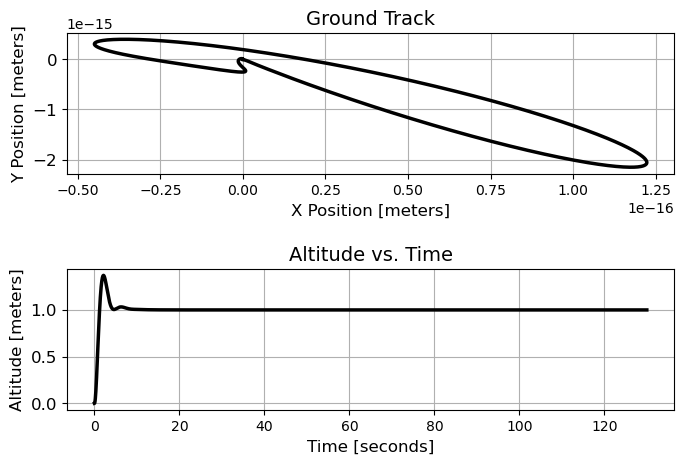

In [313]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5), sharex=False)

# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
#axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig('PP1_p1')
plt.show()

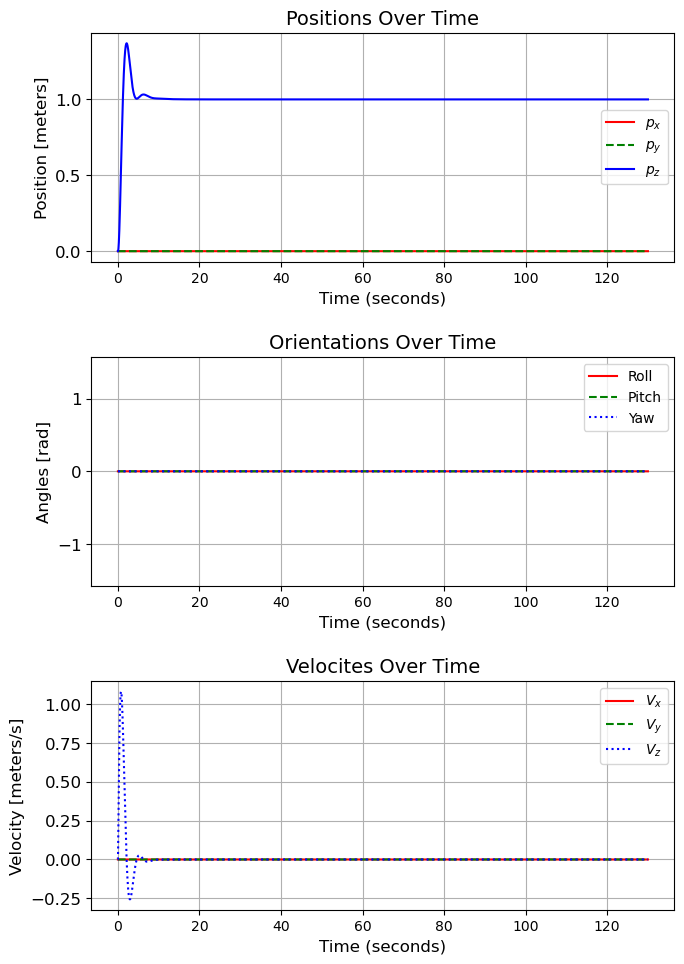

In [314]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(3, 1, figsize=(7.2, 10), sharex=False)
# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])


axes[0].plot(data['time'], pos[:,0], c="r", lw=1.5, label = '$p_x$')
axes[0].plot(data['time'], pos[:,1], c="g", linestyle='dashed', lw=1.5, label = '$p_y$')
axes[0].plot(data['time'], pos[:,2], c="b", lw=1.5, label = '$p_z$')
axes[0].set_xlabel("Time (seconds)", fontsize=12)
axes[0].set_ylabel("Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Positions Over Time", fontsize=14)
#axes[0].set_aspect('equal', 'box')
axes[0].legend()
axes[0].grid()

axes[1].plot(data['time'], rot[:,0], c="r", lw=1.5, label = 'Roll')
axes[1].plot(data['time'], rot[:,1], c="g", linestyle='dashed', lw=1.5, label = 'Pitch')
axes[1].plot(data['time'], rot[:,2], c="b", linestyle='dotted', lw=1.5, label = 'Yaw')
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].set_ylabel("Angles [rad]", fontsize=12)
axes[1].set_ylim(-np.pi/2, np.pi/2)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Orientations Over Time", fontsize=14)
#axes[1].set_aspect('equal', 'box')
axes[1].legend()
axes[1].grid()

axes[2].plot(data['time'], vel[:,0], c="r", lw=1.5, label = '$V_x$')
axes[2].plot(data['time'], vel[:,1], c="g", linestyle='dashed', lw=1.5, label = '$V_y$')
axes[2].plot(data['time'], vel[:,2], c="b", linestyle = 'dotted', lw=1.5, label = '$V_z$')
#axes[2].plot(data['time'], np.sqrt(vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2), c='k', lw=1)
axes[2].set_xlabel("Time (seconds)", fontsize=12)
axes[2].set_ylabel("Velocity [meters/s]", fontsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_title("Velocites Over Time", fontsize=14)
#axes[2].set_aspect('equal', 'box')
axes[2].legend()
axes[2].grid()
fig.tight_layout(pad=2.0)
plt.savefig('PP1_p2')

# Performance Requirement 2

In [334]:
def PG2(time):
    #Define Size of Circle
    radius = 2
    
    #Determine Speed it Travels Around
    pos = time/(2*radius)
    
    #Find x-y-z positions
    x = radius*np.cos(pos)
    y = radius*np.sin(pos)
    z = 1
    return np.array([[x],[y],[z],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

In [335]:
# Create the Controller class

class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Fixme: Implement your initialization function here


    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        
        self.xhat = np.zeros(12).reshape((12,1))
        self.xhat[2] = 1
    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """
        world_state = sim.sim.get_base_state(urdf_obj=sim.quad_obj)
        pos = world_state['position']
        rot = [world_state['roll'], world_state['pitch'], world_state['yaw']]
        velocity = world_state['velocity']
        angular_velocity = world_state['angular velocity']

        self.dt = kwargs["dt"]

        # PG2
        target = PG2(kwargs["time"])

        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rot[0]], [rot[1]], [rot[2]]]) #Sensor data
        
        dist = np.linalg.norm(target - pos)
        goal = target



        u = -K @ (self.xhat - goal)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        f_z = u[3,0] + f_z_e
        
        k = 1 #Lift Coefficient
        b = 1 #Drag Coefficient
        
        v = 0.5 #m/s
        R = 2 #m
        
        w1 = v/R
        w2 = w1
        w3 = w1
        w4 = w1
        
        self.xhat += self.dt * (A @ self.xhat + B @ u - L @ (C @ self.xhat - y)) #State estimation
        
        
        return [tau_x, tau_y, tau_z, f_z]

In [336]:
# Create an instance of the controller to send to the simulation 
controller = Controller()
# Run the simulation and collect the simulation data
data = sim.run(controller,
               collect_data=True,
               max_time=130.0,
               verbose=True)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


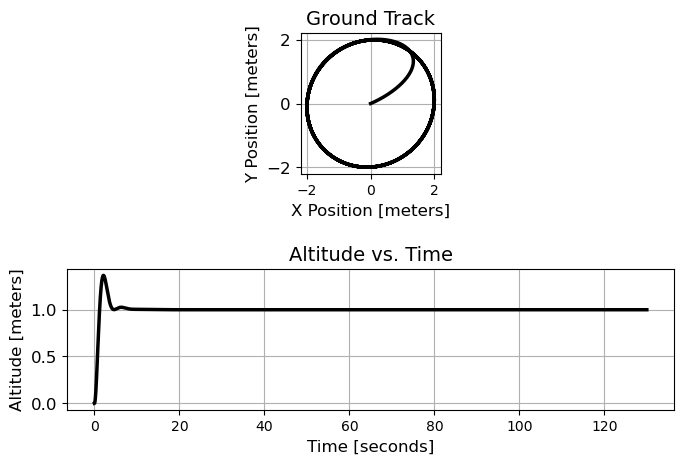

In [337]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5), sharex=False)

# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig('PP2_p1')
plt.show()

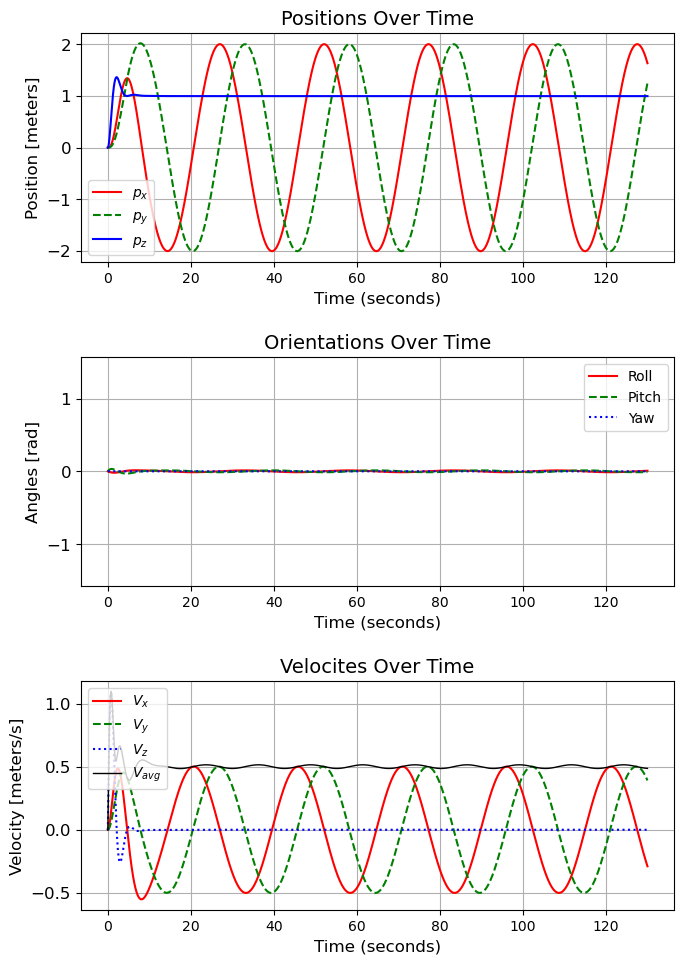

In [338]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(3, 1, figsize=(7.2, 10), sharex=False)
# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])


axes[0].plot(data['time'], pos[:,0], c="r", lw=1.5, label = '$p_x$')
axes[0].plot(data['time'], pos[:,1], c="g", linestyle='dashed', lw=1.5, label = '$p_y$')
axes[0].plot(data['time'], pos[:,2], c="b", lw=1.5, label = '$p_z$')
axes[0].set_xlabel("Time (seconds)", fontsize=12)
axes[0].set_ylabel("Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Positions Over Time", fontsize=14)
#axes[0].set_aspect('equal', 'box')
axes[0].legend()
axes[0].grid()

axes[1].plot(data['time'], rot[:,0], c="r", lw=1.5, label = 'Roll')
axes[1].plot(data['time'], rot[:,1], c="g", linestyle='dashed', lw=1.5, label = 'Pitch')
axes[1].plot(data['time'], rot[:,2], c="b", linestyle='dotted', lw=1.5, label = 'Yaw')
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].set_ylabel("Angles [rad]", fontsize=12)
axes[1].set_ylim(-np.pi/2, np.pi/2)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Orientations Over Time", fontsize=14)
#axes[1].set_aspect('equal', 'box')
axes[1].legend()
axes[1].grid()

axes[2].plot(data['time'], vel[:,0], c="r", lw=1.5, label = '$V_x$')
axes[2].plot(data['time'], vel[:,1], c="g", linestyle='dashed', lw=1.5, label = '$V_y$')
axes[2].plot(data['time'], vel[:,2], c="b", linestyle = 'dotted', lw=1.5, label = '$V_z$')
axes[2].plot(data['time'], np.sqrt(vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2), c='k', lw=1, label = '$V_{avg}$')
axes[2].set_xlabel("Time (seconds)", fontsize=12)
axes[2].set_ylabel("Velocity [meters/s]", fontsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_title("Velocites Over Time", fontsize=14)
#axes[2].set_aspect('equal', 'box')
axes[2].legend()
axes[2].grid()
fig.tight_layout(pad=2.0)
plt.savefig('PP2_p2')

# Performance Requirement 3

In [323]:
def PG3_1(time):
    #Hover 1m
    state = np.array([[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]])
    if (time <= 4):
        state[2] = 1
    elif (time <= 15):
        state[2] = 1
        state[0] = 5
    elif (time <= 30):
        state[2] = 1
        state[0] = 5
        state[5] = np.pi/2
    elif (time <= 55):
        state[2] = 1
        state[0] = 5
        state[5] = np.pi/2
        state[1] = 5
    elif (time <= 60):
        state[0] = 5
        state[2] = 1
        state[1] = 5
    elif (time <= 63):
        state[0] = 5
        state[2] = 0.8
        state[1] = 5
    elif (time <= 66):
        state[0] = 5
        state[2] = 0.6
        state[1] = 5
    elif (time <= 70):
        state[0] = 5
        state[2] = 0.4
        state[1] = 5
    elif (time <= 74):
        state[0] = 5
        state[2] = 0.2
        state[1] = 5
    else:
        state[0] = 5
        state[2] = 0
        state[1] = 5
    return state

In [324]:
# Create the Controller class
general_motor = []

class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Fixme: Implement your initialization function here


    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        
        self.xhat = np.zeros(12).reshape((12,1))
        self.xhat[2] = 1
    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """
        world_state = sim.sim.get_base_state(urdf_obj=sim.quad_obj)
        pos = world_state['position']
        rot = [world_state['roll'], world_state['pitch'], world_state['yaw']]
        velocity = world_state['velocity']
        angular_velocity = world_state['angular velocity']

        self.dt = kwargs["dt"]

        # PG3
        target = PG3_1(kwargs["time"])

        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rot[0]], [rot[1]], [rot[2]]]) #Sensor data
        
        dist = np.linalg.norm(target - pos)
        goal = target



        u = -K @ (self.xhat - goal)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        f_z = u[3,0] + f_z_e
        
        k = 1 #Lift Coefficient
        b = 1 #Drag Coefficient
        
        self.xhat += self.dt * (A @ self.xhat + B @ u - L @ (C @ self.xhat - y)) #State estimation
        
        
        return [tau_x, tau_y, tau_z, f_z]

After defining our controller class, we need to make a new instance of this class that we can pass to the simulator. This is done in the same way that we created a new instance of the simulation class above:

In [325]:
# Create an instance of the controller to send to the simulation 
controller = Controller()
# Run the simulation and collect the simulation data
data = sim.run(controller,
               collect_data=True,
               max_time=60.0,
               verbose=True)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


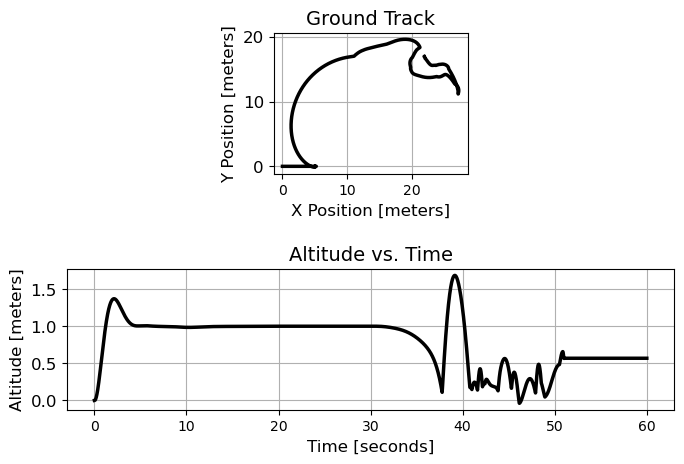

In [326]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5), sharex=False)

# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig('PP3_p1')
plt.show()

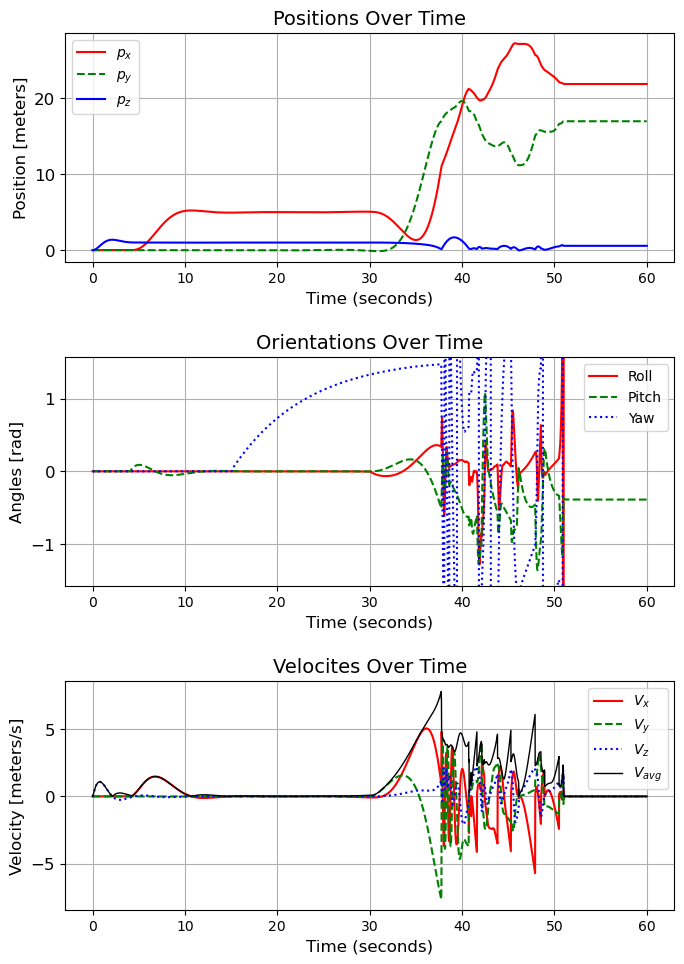

In [327]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(3, 1, figsize=(7.2, 10), sharex=False)
# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])


axes[0].plot(data['time'], pos[:,0], c="r", lw=1.5, label = '$p_x$')
axes[0].plot(data['time'], pos[:,1], c="g", linestyle='dashed', lw=1.5, label = '$p_y$')
axes[0].plot(data['time'], pos[:,2], c="b", lw=1.5, label = '$p_z$')
axes[0].set_xlabel("Time (seconds)", fontsize=12)
axes[0].set_ylabel("Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Positions Over Time", fontsize=14)
#axes[0].set_aspect('equal', 'box')
axes[0].legend()
axes[0].grid()

axes[1].plot(data['time'], rot[:,0], c="r", lw=1.5, label = 'Roll')
axes[1].plot(data['time'], rot[:,1], c="g", linestyle='dashed', lw=1.5, label = 'Pitch')
axes[1].plot(data['time'], rot[:,2], c="b", linestyle='dotted', lw=1.5, label = 'Yaw')
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].set_ylabel("Angles [rad]", fontsize=12)
axes[1].set_ylim(-np.pi/2, np.pi/2)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Orientations Over Time", fontsize=14)
#axes[1].set_aspect('equal', 'box')
axes[1].legend()
axes[1].grid()

axes[2].plot(data['time'], vel[:,0], c="r", lw=1.5, label = '$V_x$')
axes[2].plot(data['time'], vel[:,1], c="g", linestyle='dashed', lw=1.5, label = '$V_y$')
axes[2].plot(data['time'], vel[:,2], c="b", linestyle = 'dotted', lw=1.5, label = '$V_z$')
axes[2].plot(data['time'], np.sqrt(vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2), c='k', lw=1, label = '$V_{avg}$')
axes[2].set_xlabel("Time (seconds)", fontsize=12)
axes[2].set_ylabel("Velocity [meters/s]", fontsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_title("Velocites Over Time", fontsize=14)
#axes[2].set_aspect('equal', 'box')
axes[2].legend()
axes[2].grid()
fig.tight_layout(pad=2.0)
plt.savefig('PP3_p2')

In [328]:
def PG3_2(time):
    #Hover 1m
    state = np.array([[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]])
    if (time <= 4):
        state[2] = 1
    elif (time <= 15):
        state[2] = 1
        state[0] = 5
    elif (time <= 30):
        state[2] = 1
        state[0] = 5
        state[5] = np.pi/2
    elif(time <=50):
        state[2] = 1
        state[0] = 5
        state[5] = 0
    elif (time <= 55):
        state[2] = 1
        state[0] = 5
        state[5] = 0
        state[1] = 5
    elif (time <= 60):
        state[0] = 5
        state[2] = 1
        state[1] = 5
    elif (time <= 63):
        state[0] = 5
        state[2] = 0.8
        state[1] = 5
    elif (time <= 66):
        state[0] = 5
        state[2] = 0.6
        state[1] = 5
    elif (time <= 70):
        state[0] = 5
        state[2] = 0.4
        state[1] = 5
    elif (time <= 74):
        state[0] = 5
        state[2] = 0.2
        state[1] = 5
    else:
        state[0] = 5
        state[2] = 0
        state[1] = 5
    return state

In [329]:
# Create the Controller class

class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Fixme: Implement your initialization function here


    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        
        self.xhat = np.zeros(12).reshape((12,1))
        self.xhat[2] = 1
    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """
        world_state = sim.sim.get_base_state(urdf_obj=sim.quad_obj)
        pos = world_state['position']
        rot = [world_state['roll'], world_state['pitch'], world_state['yaw']]
        velocity = world_state['velocity']
        angular_velocity = world_state['angular velocity']

        self.dt = kwargs["dt"]

        # PG3
        target = PG3_2(kwargs["time"])

        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rot[0]], [rot[1]], [rot[2]]]) #Sensor data
        
        dist = np.linalg.norm(target - pos)
        goal = target



        u = -K @ (self.xhat - goal)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        f_z = u[3,0] + f_z_e
        
        k = 1 #Lift Coefficient
        b = 1 #Drag Coefficient
        
        self.xhat += self.dt * (A @ self.xhat + B @ u - L @ (C @ self.xhat - y)) #State estimation
        
        
        return [tau_x, tau_y, tau_z, f_z]

In [330]:
# Create an instance of the controller to send to the simulation 
controller = Controller()
# Run the simulation and collect the simulation data
data = sim.run(controller,
               collect_data=True,
               max_time=100.0,
               verbose=True)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...


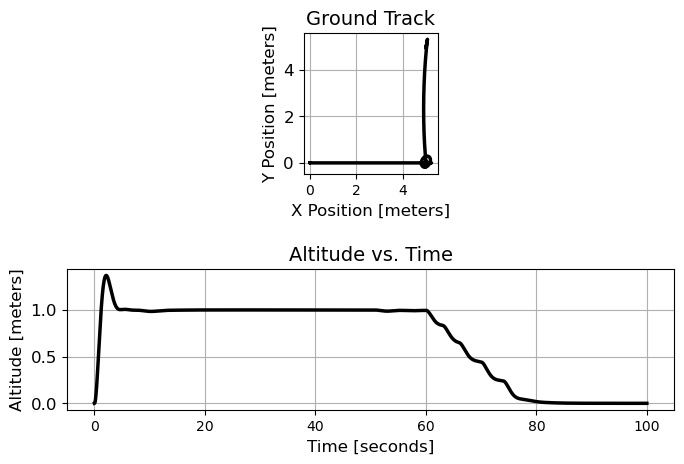

In [331]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5), sharex=False)

# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.savefig('PP3_p3')
plt.show()

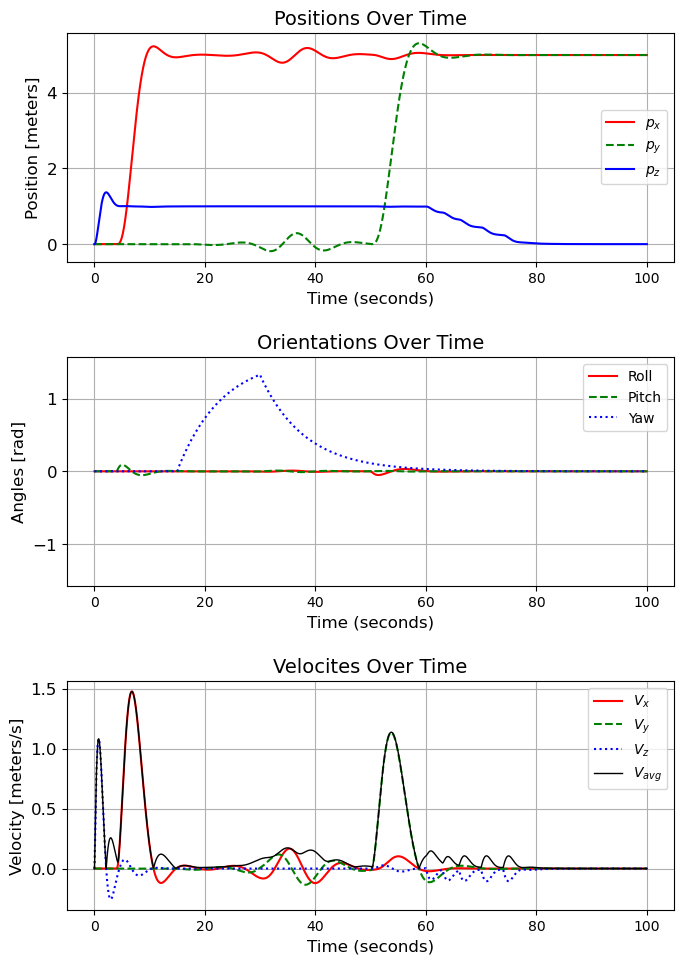

In [332]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(3, 1, figsize=(7.2, 10), sharex=False)
# Convert the position data to array
# Get the position
pos = np.array(data['position'])
rot = np.array(data['orientation'])
vel = np.array(data['velocity'])
ang = np.array(data['angular velocity'])
inp = np.array(data['inputs'])


axes[0].plot(data['time'], pos[:,0], c="r", lw=1.5, label = '$p_x$')
axes[0].plot(data['time'], pos[:,1], c="g", linestyle='dashed', lw=1.5, label = '$p_y$')
axes[0].plot(data['time'], pos[:,2], c="b", lw=1.5, label = '$p_z$')
axes[0].set_xlabel("Time (seconds)", fontsize=12)
axes[0].set_ylabel("Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Positions Over Time", fontsize=14)
#axes[0].set_aspect('equal', 'box')
axes[0].legend()
axes[0].grid()

axes[1].plot(data['time'], rot[:,0], c="r", lw=1.5, label = 'Roll')
axes[1].plot(data['time'], rot[:,1], c="g", linestyle='dashed', lw=1.5, label = 'Pitch')
axes[1].plot(data['time'], rot[:,2], c="b", linestyle='dotted', lw=1.5, label = 'Yaw')
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].set_ylabel("Angles [rad]", fontsize=12)
axes[1].set_ylim(-np.pi/2, np.pi/2)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Orientations Over Time", fontsize=14)
#axes[1].set_aspect('equal', 'box')
axes[1].legend()
axes[1].grid()

axes[2].plot(data['time'], vel[:,0], c="r", lw=1.5, label = '$V_x$')
axes[2].plot(data['time'], vel[:,1], c="g", linestyle='dashed', lw=1.5, label = '$V_y$')
axes[2].plot(data['time'], vel[:,2], c="b", linestyle = 'dotted', lw=1.5, label = '$V_z$')
axes[2].plot(data['time'], np.sqrt(vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2), c='k', lw=1, label = '$V_{avg}$')
axes[2].set_xlabel("Time (seconds)", fontsize=12)
axes[2].set_ylabel("Velocity [meters/s]", fontsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_title("Velocites Over Time", fontsize=14)
#axes[2].set_aspect('equal', 'box')
axes[2].legend()
axes[2].grid()
fig.tight_layout(pad=2.0)
plt.savefig('PP3_p4')
display((vel[:,0][500] + vel[:,0][600] + vel[:,0][700] + vel[:,0][800] + vel[:,0][900]) / 5)
display((vel[:,1][5200] + vel[:,1][5300] + vel[:,1][5400] + vel[:,1][5500] + vel[:,1][5600]) / 5)